In [1]:
import numpy as np 
import pandas as pd 
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_dir = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Train'
test_dir = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Test'
val_dir = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation'

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    verbose = 1
)


Epoch 1/10
18/18 [==============================] - 27s 989ms/step - loss: 0.9273 - accuracy: 0.5722 - val_loss: 0.5040 - val_accuracy: 0.8368
Epoch 2/10
18/18 [==============================] - 16s 902ms/step - loss: 0.4819 - accuracy: 0.7852 - val_loss: 0.3560 - val_accuracy: 0.8715
Epoch 3/10
18/18 [==============================] - 15s 860ms/step - loss: 0.3681 - accuracy: 0.8539 - val_loss: 0.2647 - val_accuracy: 0.8889
Epoch 4/10
18/18 [==============================] - 16s 915ms/step - loss: 0.3277 - accuracy: 0.8768 - val_loss: 0.2415 - val_accuracy: 0.9201
Epoch 5/10
18/18 [==============================] - 15s 826ms/step - loss: 0.3121 - accuracy: 0.8732 - val_loss: 0.2828 - val_accuracy: 0.8958
Epoch 6/10
18/18 [==============================] - 15s 874ms/step - loss: 0.2956 - accuracy: 0.8838 - val_loss: 0.2365 - val_accuracy: 0.9132
Epoch 7/10
18/18 [==============================] - 15s 871ms/step - loss: 0.2976 - accuracy: 0.8803 - val_loss: 0.2572 - val_accuracy: 0.8958

In [8]:
image_paths = ['/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Mask/1701.jpg', '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/real_00007.jpg']

images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (224, 224))  # Resize to match model input shape
    image = image / 255.0  # Normalize pixel values
    images.append(image)

images = np.array(images)


In [16]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 20ms/step


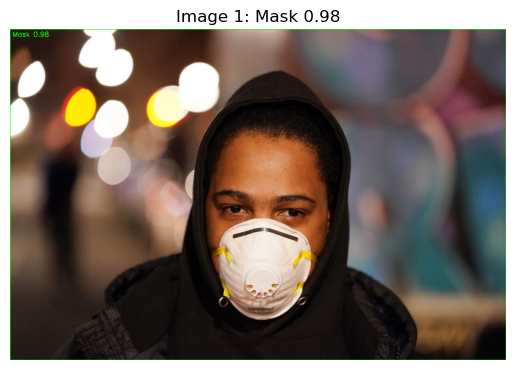

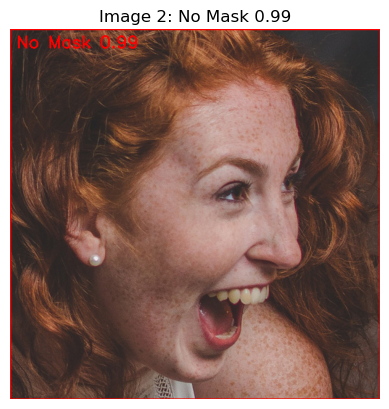

In [17]:
predictions = model.predict(images)

for i, prediction in enumerate(predictions):
    label = "Mask" if prediction < 0.5 else "No Mask"
    confidence = 1 - prediction[0] if label == "Mask" else prediction[0]

    #print(f"Image {i+1}: {label} with confidence {confidence:.2f}")
    
    image = cv2.imread(image_paths[i])

    # Draw a bounding box around the face
    if label == "Mask":
        color = (0, 255, 0)  # Green color for Mask
    else:
        color = (0, 0, 255)  # Red color for No Mask

    cv2.rectangle(image, (0, 0), (image.shape[1], image.shape[0]), color, 2)

    # Add label and confidence text
    text = f"{label} {confidence:.2f}"
    cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the image with bounding box
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1}: {label} {confidence:.2f}")
    plt.axis('off')
    plt.show()
    